## Example: Autoencoder for dimensionality reduction (aka "Manifold learning") 

### Generate some test data
* Here we use numpy and matplotlib
* Two examples of 1D submanifolds in $\mathbb{R}^2$: a straight line and a spiral
* Parameterise $v=(x,y)=F(u)$ by input $u=(\varphi,\vartheta)$, with 1D dependency $F=F(\varphi)$ and dummy $\vartheta$
* Add some noise to emulate realistic conditions and avoid flat gradients

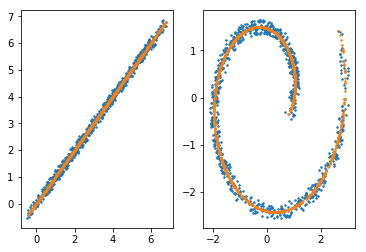

In [46]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.3 # spirality
noi = 0.3 # noise

ph = np.linspace(0, 2*np.pi, 30) # variable that introduces 1D dependency
th = np.linspace(0, 2*np.pi, 30) # mock variable, no dependency

[PH, TH] = np.meshgrid(ph,th)
PH = PH.flatten(); TH = TH.flatten();
PH = PH + (np.random.rand(len(PH))-.5) # redistribute a bit
TH = TH + (np.random.rand(len(PH))-.5)

R = 1.0 + alpha*PH

# Curve 1: straight line
curve1 = np.array([PH, PH])
curve1n = curve1 + noi*(np.random.rand(curve1.shape[0],curve1.shape[1])-.5)

# Curve 2: straight line
curve2 = np.array([R*np.cos(PH), R*np.sin(PH)])
curve2n = curve2 + noi*(np.random.rand(curve2.shape[0],curve2.shape[1])-.5)

plt.figure()

plt.subplot(1,2,1)
plt.plot(curve1n[0,:], curve1n[1,:], '.', markersize=3)
plt.plot(curve1[0,:], curve1[1,:], '.', markersize=3)

plt.subplot(1,2,2)
plt.plot(curve2n[0,:], curve2n[1,:], '.', markersize=3)
plt.plot(curve2[0,:], curve2[1,:], '.', markersize=3)

plt.show()

### Import models, layers and optimizers from Keras

In [47]:
# Keras frontend inside tensorflow > 1.4
import tensorflow as tf
from tensorflow import keras

# Alternative: standalone Keras with custom backend
# import os
# os.environ['KERAS_BACKEND'] = 'theano' # 'cntk', 'tensorflow', or 'theano'
# from keras import models, layers, optimizers

### Build model
* our first example is a linear function
* use linear or "leaky" relu or activation function (usual relu cuts away negative part)
* linear autoencoder corresponds to PCA/SVD/POD

In [48]:
# Functional api
inputs = keras.layers.Input(shape=(2,)) # 2 input nodes
layer1 = keras.layers.Dense(1, activation='linear')(inputs)  # compress to a single node
outputs = keras.layers.Dense(2, activation='linear')(layer1) # extend to 2 output nodes
model = keras.models.Model(inputs=inputs, outputs=outputs)

# Alternative: Sequential api (see below)

### Visualise model


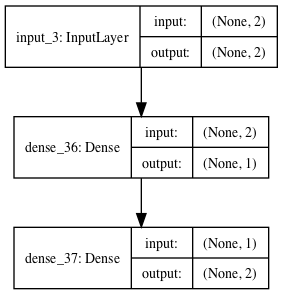

In [49]:
from tensorflow.python.keras.utils import plot_model
from IPython import display

# from https://medium.com/@zhang_yang/how-to-plot-keras-models-493469884fd5

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
display.Image('model.png')

# Alternative with standalone keras:
# from keras.utils.vis_utils import model_to_dot
# display.SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

### Optimizers: Stochastic gradient descent
* Adam: Adaptive moment estimation - "damped ball rolling in potential well"<br>
D.P. Kingma and B. Jimmy. arXiv preprint arXiv:1412.6980 (2014).
* RMSprop: stoch. grad. desc. with dynamically adjusting learning rate<br>
G. Hinton, lecture slides http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf

Source: http://ruder.io/optimizing-gradient-descent/

In [50]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='mse')           # loss function, mae = mean abs. err., mse = mean square err.

model.save_weights('model.h5')      # save weights for later

## Train model

* Get data to the right shape for Keras
* Normalise data to be in range (0,1) for all dimensions
* Use `train_test_split` from scikit-learn to automatically
split data into some training and test (validation) data.


In [51]:
# need to transpose first axis should be index in dataset
input_all = np.array([PH, TH]).T 
output_all = curve1n.T

# normalisation, especially if using sigmoid mapping to (0,1) at output
input_all = (input_all - np.min(input_all,0))/np.max(input_all - np.min(input_all,0),0)
output_all = (output_all - np.min(output_all,0))/np.max(output_all - np.min(output_all,0),0)

# from sklearn.model_selection import train_test_split
input_train, input_test, output_train, output_test = train_test_split(
     input_all, output_all, test_size=0.33, random_state=13)

# for tensorboard diagnostics, see https://stackoverflow.com/questions/42112260/how-do-i-use-the-tensorboard-callback-of-keras
# start tensorboard with tensorboard --logdir path_to_current_dir/tb 
tb_callback = keras.callbacks.TensorBoard(log_dir='./tb', histogram_freq=0, write_graph=True, write_images=True)

model.load_weights('model.h5') # load initial weights to start from scratch every time
history = model.fit(           # save training history
    input_train, output_train, # training input and output
    batch_size=16,             # no. of training pairs to process in parallel while optimising
    epochs=128,                # no. of cycles over whole training set while optimising
    callbacks=[tb_callback]
)

Epoch 1/128
603/603 [==============================] - 0s 273us/step - loss: 0.0439
Epoch 2/128
603/603 [==============================] - 0s 66us/step - loss: 0.0242
Epoch 3/128
603/603 [==============================] - 0s 68us/step - loss: 0.0176
Epoch 4/128
603/603 [==============================] - 0s 69us/step - loss: 0.0152
Epoch 5/128
603/603 [==============================] - 0s 72us/step - loss: 0.0140
Epoch 6/128
603/603 [==============================] - 0s 75us/step - loss: 0.0129
Epoch 7/128
603/603 [==============================] - 0s 73us/step - loss: 0.0119
Epoch 8/128
603/603 [==============================] - 0s 66us/step - loss: 0.0110
Epoch 9/128
603/603 [==============================] - 0s 65us/step - loss: 0.0100
Epoch 10/128
603/603 [==============================] - 0s 66us/step - loss: 0.0091
Epoch 11/128
603/603 [==============================] - 0s 66us/step - loss: 0.0083
Epoch 12/128
603/603 [==============================] - 0s 66us/step - loss: 0.0075


603/603 [==============================] - 0s 62us/step - loss: 1.4102e-04
Epoch 96/128
603/603 [==============================] - 0s 61us/step - loss: 1.4064e-04
Epoch 97/128
603/603 [==============================] - 0s 68us/step - loss: 1.3882e-04
Epoch 98/128
603/603 [==============================] - 0s 57us/step - loss: 1.3933e-04
Epoch 99/128
603/603 [==============================] - 0s 62us/step - loss: 1.4246e-04
Epoch 100/128
603/603 [==============================] - 0s 60us/step - loss: 1.4039e-04
Epoch 101/128
603/603 [==============================] - 0s 63us/step - loss: 1.4002e-04
Epoch 102/128
603/603 [==============================] - 0s 63us/step - loss: 1.4084e-04
Epoch 103/128
603/603 [==============================] - 0s 60us/step - loss: 1.4006e-04
Epoch 104/128
603/603 [==============================] - 0s 61us/step - loss: 1.3926e-04
Epoch 105/128
603/603 [==============================] - 0s 62us/step - loss: 1.3944e-04
Epoch 106/128
603/603 [================

### Plot diagnostics and results

dict_keys(['loss'])


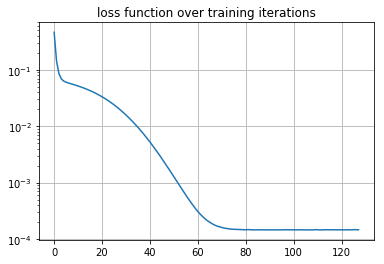

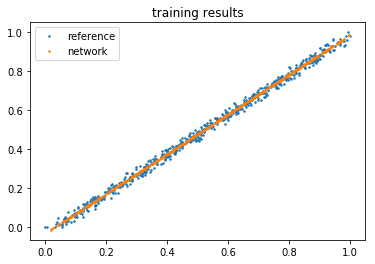

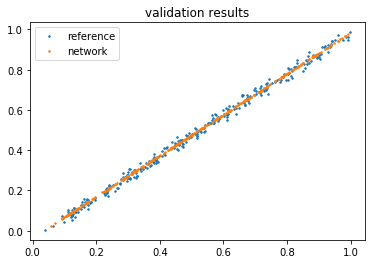

In [21]:
output_eval_train = model.predict(input_train)
output_eval_test = model.predict(input_test)

# plot diagnostics, 
# see https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
print(history.history.keys())
plt.figure()
plt.semilogy(history.history['loss'])
plt.grid(True)
plt.title('loss function over training iterations')

plt.figure()
plt.plot(output_train[:,0], output_train[:,1], '.', markersize=3)
plt.plot(output_eval_train[:,0], output_eval_train[:,1], '.', markersize=3)
plt.title('training results')
plt.legend(['reference', 'network'])
plt.figure()
plt.plot(output_test[:,0], output_test[:,1], '.', markersize=3)
plt.plot(output_eval_test[:,0], output_eval_test[:,1], '.', markersize=3)
plt.title('validation results')
plt.legend(['reference', 'network'])
plt.show()

### Bigger and nonlinear network
* Need more degrees of freedom to handle spiral
* Nonlinear activation function to reproduce nonlinear function
* Some intermediate layers to reduce jumps in node count

In [44]:
# Sequential api
model2 = keras.Sequential()
model2.add(keras.layers.Dense(16, input_dim=2, activation=tf.nn.tanh))
model2.add(keras.layers.Dense(256, activation=tf.nn.tanh))
model2.add(keras.layers.Dense(16, activation=tf.nn.tanh))
model2.add(keras.layers.Dense(1, activation=tf.nn.tanh))
model2.add(keras.layers.Dense(16, activation=tf.nn.tanh))
model2.add(keras.layers.Dense(256, activation=tf.nn.tanh))
model2.add(keras.layers.Dense(16, activation=tf.nn.tanh))
model2.add(keras.layers.Dense(2, activation=tf.nn.sigmoid))

model2.compile(optimizer=tf.train.AdamOptimizer(), loss='mse')

input_all = np.array([PH, TH]).T 
output_all = curve2n.T

input_all = (input_all - np.min(input_all,0))/np.max(input_all - np.min(input_all,0),0)
output_all = (output_all - np.min(output_all,0))/np.max(output_all - np.min(output_all,0),0)

input_train, input_test, output_train, output_test = train_test_split(
     input_all, output_all, test_size = 0.33, random_state = 13)

tb_callback = keras.callbacks.TensorBoard(log_dir='./tb', histogram_freq=0, write_graph=True, write_images=True)

history = model2.fit(input_train, output_train, batch_size = 16, epochs = 128, callbacks=[tb_callback])


Epoch 1/128
603/603 [==============================] - 1s 1ms/step - loss: 0.0770
Epoch 2/128
603/603 [==============================] - 0s 122us/step - loss: 0.0755
Epoch 3/128
603/603 [==============================] - 0s 109us/step - loss: 0.0740
Epoch 4/128
603/603 [==============================] - 0s 101us/step - loss: 0.0735
Epoch 5/128
603/603 [==============================] - 0s 103us/step - loss: 0.0739
Epoch 6/128
603/603 [==============================] - 0s 101us/step - loss: 0.0719
Epoch 7/128
603/603 [==============================] - 0s 106us/step - loss: 0.0720
Epoch 8/128
603/603 [==============================] - 0s 105us/step - loss: 0.0686
Epoch 9/128
603/603 [==============================] - 0s 103us/step - loss: 0.0598
Epoch 10/128
603/603 [==============================] - 0s 108us/step - loss: 0.0499
Epoch 11/128
603/603 [==============================] - 0s 114us/step - loss: 0.0430
Epoch 12/128
603/603 [==============================] - 0s 114us/step - loss

603/603 [==============================] - 0s 102us/step - loss: 5.8418e-04
Epoch 96/128
603/603 [==============================] - 0s 101us/step - loss: 6.5822e-04
Epoch 97/128
603/603 [==============================] - 0s 111us/step - loss: 8.0672e-04
Epoch 98/128
603/603 [==============================] - 0s 112us/step - loss: 5.6559e-04
Epoch 99/128
603/603 [==============================] - 0s 101us/step - loss: 8.0174e-04
Epoch 100/128
603/603 [==============================] - 0s 96us/step - loss: 7.0410e-04
Epoch 101/128
603/603 [==============================] - 0s 100us/step - loss: 7.6152e-04
Epoch 102/128
603/603 [==============================] - 0s 103us/step - loss: 6.7357e-04
Epoch 103/128
603/603 [==============================] - 0s 94us/step - loss: 5.8877e-04
Epoch 104/128
603/603 [==============================] - 0s 99us/step - loss: 5.1703e-04
Epoch 105/128
603/603 [==============================] - 0s 99us/step - loss: 4.9635e-04
Epoch 106/128
603/603 [=========

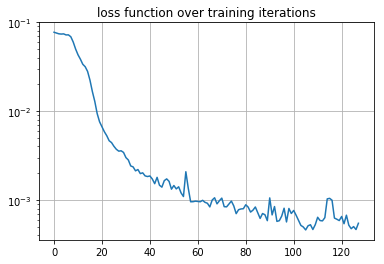

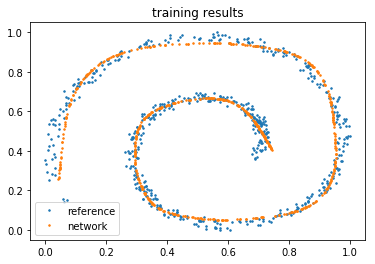

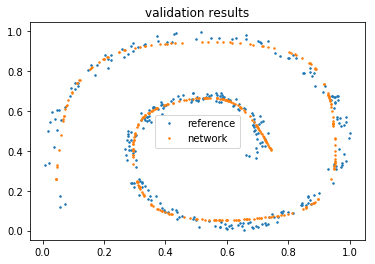

In [45]:
output_eval_train = model2.predict(input_train)
output_eval_test = model2.predict(input_test)

plt.figure()
plt.semilogy(history.history['loss'])
plt.grid(True)
plt.title('loss function over training iterations')

plt.figure()
plt.plot(output_train[:,0], output_train[:,1], '.', markersize=3)
plt.plot(output_eval_train[:,0], output_eval_train[:,1], '.', markersize=3)
plt.title('training results')
plt.legend(['reference', 'network'])
plt.figure()
plt.plot(output_test[:,0], output_test[:,1], '.', markersize=3)
plt.plot(output_eval_test[:,0], output_eval_test[:,1], '.', markersize=3)
plt.title('validation results')
plt.legend(['reference', 'network'])
plt.show()

## Sensitivity analysis

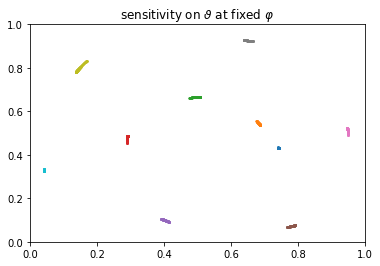

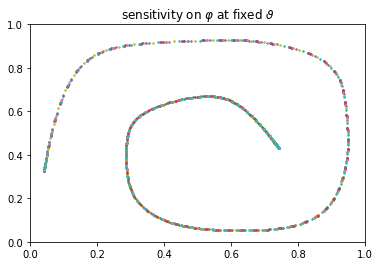

In [43]:
plt.figure()
for k in np.linspace(0,1,10):
    input_sens1 = np.array([k*np.ones(100), np.linspace(0,1,100)]).T
    output_sens1 = model2.predict(input_sens1)
    plt.plot(output_sens1[:,0], output_sens1[:,1], '.', markersize=3)
    plt.xlim([0,1]); plt.ylim([0,1])
plt.title(r'sensitivity on $\vartheta$ at fixed $\varphi$')

plt.figure()
for k in np.linspace(0,1,10):
    input_sens2 = np.array([np.linspace(0,1,100),k*np.ones(100)]).T
    output_sens2 = model2.predict(input_sens2)
    plt.plot(output_sens2[:,0], output_sens2[:,1], '.', markersize=3)
    plt.xlim([0,1]); plt.ylim([0,1])
plt.title(r'sensitivity on $\varphi$ at fixed $\vartheta$')
    
plt.show()